# Intro

As the title indicates, this ipynb aims to import dataframes (features plus labels) and then develop functions / clases to process data, fit models, and make predictions!

# Import data (just for materialHardship)

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import sys
import math
# from sklearn.grid_search import GridSearchCV

In [2]:
mean_impute_df_train_with_labels = pd.read_pickle('Data/mean_impute_df_train_with_labels')
median_impute_df_train_with_labels  = pd.read_pickle('Data/median_impute_df_train_with_labels')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/mean_impute_df_train_with_labels'

In [3]:
final_over_balanced =  pd.read_pickle('final_over_balanced_decimals')

In [4]:
df_prediction =  pd.read_pickle('df_prediction')

Read files from pickles...we are reading full dataframes, with columns of features attached to label columns. Function below is used to split features from class labels and make models and predictions.

# Train

## Prepare data

Split features and labels.

In [5]:
# split data into features and labels
def split_data(df, label='materialHardship'):
    copy = df.copy() # copy df so i dont alter original df by popping
    y = copy.pop(label) # pop label
    return copy, y

Return features and labels...feed split_data function a full data frame. This can be any from the above imports.

In [6]:
copy, mh = split_data(median_impute_df_train_with_labels)

Test_train split. I call the test data the "validation" data because I think it is a better, less ambiguous term.

In [7]:
x_train_med, x_valid_med, y_train_med, y_valid_med = train_test_split(copy, mh, test_size=0.2) #train test split

In [24]:
num_rd = [1,5]
i=1
paramms = {
        "eval_metric" : 'rmse',
        'objective' : 'reg:logistic',
        'eta' : 1,
        'max_depth': 1
       }

In [33]:
d_train = xgb.DMatrix(x_train_med,y_train_med/11) # make training matrix
d_valid = xgb.DMatrix(x_valid_med,y_valid_med/11) # make valid matrix
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params=paramms,  # train on train matrix with params
            dtrain=d_train,
            evals = watchlist,
         num_boost_round=110) 

[0]	train-rmse:0.165208	valid-rmse:0.167366
[1]	train-rmse:0.146634	valid-rmse:0.148812
[2]	train-rmse:0.142543	valid-rmse:0.1524
[3]	train-rmse:0.140582	valid-rmse:0.153174
[4]	train-rmse:0.139138	valid-rmse:0.151126
[5]	train-rmse:0.136243	valid-rmse:0.152386
[6]	train-rmse:0.135252	valid-rmse:0.150792
[7]	train-rmse:0.133376	valid-rmse:0.1508
[8]	train-rmse:0.131582	valid-rmse:0.151857
[9]	train-rmse:0.130457	valid-rmse:0.152296
[10]	train-rmse:0.128985	valid-rmse:0.152222
[11]	train-rmse:0.127251	valid-rmse:0.154056
[12]	train-rmse:0.126129	valid-rmse:0.156677
[13]	train-rmse:0.125491	valid-rmse:0.156607
[14]	train-rmse:0.124075	valid-rmse:0.154831
[15]	train-rmse:0.123678	valid-rmse:0.156836
[16]	train-rmse:0.122783	valid-rmse:0.156009
[17]	train-rmse:0.12193	valid-rmse:0.156241
[18]	train-rmse:0.120896	valid-rmse:0.156235
[19]	train-rmse:0.119845	valid-rmse:0.157519
[20]	train-rmse:0.118846	valid-rmse:0.158999
[21]	train-rmse:0.118035	valid-rmse:0.160073
[22]	train-rmse:0.11779	v

In [12]:
df_prediction_good_cols = df_prediction[x_train_med.columns.values] # keep the columns that are in training data...

In [13]:
bst.predict(xgb.DMatrix(df_prediction_good_cols))

array([ 0.06372276,  0.09408692,  0.10678589, ...,  0.12403089,
        0.03858319,  0.03551216], dtype=float32)

In [15]:
d = bst.get_fscore()

def get_feature_df(d):
    '''given xgboost feature score object
    put into pretty df'''
    feature = []
    f_importance = []
    for w in sorted(d, key=d.get, reverse=True):
        feature.append(w)
        f_importance.append(d[w])

    feature_import_df = pd.DataFrame(
        {'feature': feature,
         'feature importance': f_importance,
        })
    return feature_import_df

In [16]:
get_feature_df(d).head()

,feature,feature importance
0,m4i23o,1
1,m5f23e,1
2,m5f23a,1
3,hv5_mwtlb,1
4,p5q3k,1


In [18]:
predy = bst.predict(xgb.DMatrix(df_prediction_good_cols))

In [20]:
train_preds = bst.predict(xgb.DMatrix(x_train_med))

In [21]:
predy

array([ 0.06372276,  0.09408692,  0.10678589, ...,  0.12403089,
        0.03858319,  0.03551216], dtype=float32)

In [22]:
train_preds

array([ 0.03551216,  0.01381226,  0.09715381, ...,  0.0935094 ,
        0.0349783 ,  0.08616438], dtype=float32)

In [23]:
mean_squared_error(y_train_med, train_preds)

3.7765038414097667

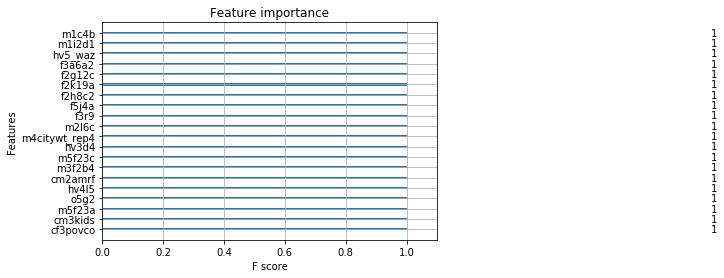

In [37]:
xgb.plot_importance(bst,max_num_features=20)
plt.show()

# Parameter selection here!

## Below...plug in some parameters you would like to choose between. This has only 1 for loop at the moment, indicating that you can only loop through a list of 1 parameter. Obviously, this is complicated, because certain parameters (all parameters?) interact, so it would probably be better to loop through multiple at a time. I could write code to do this, but this works fine for now to just investigate one. 

In [44]:
# where errors go 
errs = []
models = []
# PARAMS
########
paramms = {
            "eval_metric" : 'rmse',
            'objective' : 'reg:logistic',
            'eta' : 1,
            'max_depth': 1
           }
num_rd = [1,10]
# TRAININGS
########

for i in range(len(num_rd)):    # params!
    d_train = xgb.DMatrix(x_train_med,y_train_med/11) # make training matrix
    d_valid = xgb.DMatrix(x_valid_med,y_valid_med/11) # make valid matrix
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    print('training model {}'.format(i))
    bst = xgb.train(params=paramms,  # train on train matrix with params
                dtrain=d_train,
                evals = watchlist,
             num_boost_round=num_rd[i]) 
    models.append(bst) # add model to list of models we have tried
    # errors
    train_preds = bst.predict(xgb.DMatrix(x_train_med))
    mse = mean_squared_error(y_train_med, train_preds) 
    errs.append(mse) # add mse to list

training model 0
[0]	train-rmse:0.165208	valid-rmse:0.167366
training model 1
[0]	train-rmse:0.165208	valid-rmse:0.167366
[1]	train-rmse:0.146634	valid-rmse:0.148812
[2]	train-rmse:0.142543	valid-rmse:0.1524
[3]	train-rmse:0.140582	valid-rmse:0.153174
[4]	train-rmse:0.139138	valid-rmse:0.151126
[5]	train-rmse:0.136243	valid-rmse:0.152386
[6]	train-rmse:0.135252	valid-rmse:0.150792
[7]	train-rmse:0.133376	valid-rmse:0.1508
[8]	train-rmse:0.131582	valid-rmse:0.151857
[9]	train-rmse:0.130457	valid-rmse:0.152296


In [46]:
models

[<xgboost.core.Booster at 0x12472b198>, <xgboost.core.Booster at 0x12472b048>]

# FINALLY

jeez...spent too much time trying to finesse. tried to work with classes. tried to use sklearn grid search. this was much easier. i can clean up a bit, but this isn't that hard to plug into. now i can try different parameters and pick model with lowest vlaidation error!

# Create Submission file

In [129]:
# Need to add train labels to submission too, I think
print('create submission')
preds = pd.DataFrame()
preds['challengeID'] = df_prediction['challengeID']
preds['materialHardship'] = p_test
preds.sort_values(by='challengeID').head(10)

create submission


,challengeID,materialHardship
0,1,0.228553
1,2,0.208423
2,3,0.192934
3,4,0.217176
4,5,0.100321
7,8,0.186167
10,11,0.210725
11,12,0.084569
14,15,0.121868
16,17,0.103562


In [131]:
# tack on given train values
sub = preds.append(non_na_y_train_materialHardship)
sub.sort_values(by='challengeID').head(15)

sub.to_csv('simple_xgb.csv', index=False)

Here, we send in a submission that predicts all missing values (both missing MH values from train set and also values for IDs that were never in train to start). 